In [1]:
# -*- coding: utf-8 -*-


import os
import gc
import numpy as np
import pandas as pd
from scipy.stats import kurtosis


RANDOM_STATE = 42
pd.set_option('future.no_silent_downcasting', True)



def reduce_memory_usage(df: pd.DataFrame, verbose=True):

    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if pd.api.types.is_numeric_dtype(col_type):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                # float
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f"Mem. usage decreased to {end_mem:.2f} MB ({100*(start_mem - end_mem)/start_mem:.1f}% reduction)")
    return df


def one_hot_encoder(df: pd.DataFrame, nan_as_category=True):

    original_cols = list(df.columns)
    df = pd.get_dummies(df, dummy_na=nan_as_category)
    new_cols = [c for c in df.columns if c not in original_cols]
    return df, new_cols


def agg_numeric(df, group_var, df_name):

    df = df.select_dtypes(include=['number', 'bool', 'int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
    agg = df.groupby(group_var).agg(['count','mean','max','min','sum','var'])
    # 展平多级列名：dfname_col_stat
    agg.columns = [f"{df_name}_{c[0]}_{c[1].upper()}" for c in agg.columns]
    agg.reset_index(inplace=True)
    return agg


def agg_categorical(df, group_var, df_name):

    cat_cols = [c for c in df.columns if any(s in c for s in ['_nan', '_NaN']) or df[c].nunique() == 2]
    if len(cat_cols) == 0:
        cat_cols = [c for c in df.columns if df[c].nunique() <= 10 and c != group_var]
    if len(cat_cols) == 0:
        return None

    cats = df[[group_var] + cat_cols]
    agg = cats.groupby(group_var).agg(['sum', 'mean'])
    agg.columns = [f"{df_name}_{c[0]}_{c[1].upper()}" for c in agg.columns]
    agg.reset_index(inplace=True)
    return agg


def safe_merge(left, right, on, how='left'):
    if right is None:
        return left
    return left.merge(right, on=on, how=how)




def process_applications(data_dir):
    train = pd.read_csv(os.path.join(data_dir, 'application_train.csv'))
    test  = pd.read_csv(os.path.join(data_dir, 'application_test.csv'))
    print(f"Loaded application: train={train.shape}, test={test.shape}")

    y = train['TARGET'].copy()
    test['TARGET'] = np.nan
    app = pd.concat([train, test], axis=0, ignore_index=True)


    app['DAYS_EMPLOYED'] = app['DAYS_EMPLOYED'].replace(365243, np.nan)


    app['DAYS_BIRTH_ABS'] = app['DAYS_BIRTH'].abs()
    app['YEARS_BIRTH'] = app['DAYS_BIRTH_ABS'] / 365.0
    app['YEARS_EMPLOYED'] = app['DAYS_EMPLOYED'].abs() / 365.0

    app['ANNUITY_INCOME_PERC']  = app['AMT_ANNUITY'] / (app['AMT_INCOME_TOTAL'] + 1e-5)
    app['CREDIT_INCOME_PERC']   = app['AMT_CREDIT'] / (app['AMT_INCOME_TOTAL'] + 1e-5)
    app['INCOME_CREDIT_PERC']   = app['AMT_INCOME_TOTAL'] / (app['AMT_CREDIT'] + 1e-5)
    app['INCOME_PER_PERSON']    = app['AMT_INCOME_TOTAL'] / (app['CNT_FAM_MEMBERS'] + 1e-5)
    app['ANNUITY_LENGTH']       = app['AMT_CREDIT'] / (app['AMT_ANNUITY'] + 1e-5)
    app['CREDIT_TO_GOODS_RATIO']= app['AMT_CREDIT'] / (app['AMT_GOODS_PRICE'] + 1e-5)
    app['CREDIT_TERM']          = app['AMT_ANNUITY'] / (app['AMT_CREDIT'] + 1e-5)


    ext_sources = [c for c in ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'] if c in app.columns]
    if ext_sources:
        app['EXT_SOURCES_MEAN'] = app[ext_sources].mean(axis=1)
        app['EXT_SOURCES_STD']  = app[ext_sources].std(axis=1)
        app['EXT_SOURCES_MIN']  = app[ext_sources].min(axis=1)
        app['EXT_SOURCES_MAX']  = app[ext_sources].max(axis=1)
        app['SOURCES_PROD']     = app[ext_sources].fillna(1.0).prod(axis=1)


    app['EMPLOY_TO_BIRTH_RATIO'] = app['DAYS_EMPLOYED'].abs() / (app['DAYS_BIRTH'].abs() + 1e-5)


    flag_cols = [c for c in app.columns if c.startswith('FLAG_')]

    doc_cols = [c for c in app.columns if c.startswith('FLAG_DOCUMENT_')]
    if doc_cols:
        app[doc_cols] = app[doc_cols].apply(pd.to_numeric, errors='coerce')


    num_flag_cols = [c for c in flag_cols if pd.api.types.is_numeric_dtype(app[c])]
    if num_flag_cols:
        app['FLAG_SUM'] = app[num_flag_cols].sum(axis=1)


    if doc_cols:
        doc_matrix = app[doc_cols].fillna(0).astype(np.float32).to_numpy()
        app['DOC_IND_KURT'] = pd.Series(
            np.apply_along_axis(lambda r: kurtosis(r, fisher=True, nan_policy='omit'), 1, doc_matrix),
            index=app.index
        ).astype(np.float32)


    if 'ORGANIZATION_TYPE' in app.columns:
        inc_by_org = app.groupby('ORGANIZATION_TYPE')['AMT_INCOME_TOTAL'].median()
        app['NEW_INC_BY_ORG'] = app['ORGANIZATION_TYPE'].map(inc_by_org)


    app, app_cat_cols = one_hot_encoder(app, nan_as_category=True)
    app = reduce_memory_usage(app)


    train_processed = app[~app['TARGET'].isna()].copy()
    test_processed  = app[ app['TARGET'].isna()].copy()
    train_processed.drop(columns=['TARGET'], inplace=True)
    test_processed.drop(columns=['TARGET'], inplace=True)


    y = y.loc[train_processed.index].astype(np.int8)

    return train_processed, y, test_processed




def process_bureau_and_balance(data_dir):
    bureau = pd.read_csv(os.path.join(data_dir, 'bureau.csv'))
    bb_path = os.path.join(data_dir, 'bureau_balance.csv')
    print(f"Loaded bureau: {bureau.shape}")

    if os.path.exists(bb_path):
        bb = pd.read_csv(bb_path)
        print(f"Loaded bureau_balance: {bb.shape}")


        bb, _ = one_hot_encoder(bb, nan_as_category=True)
        bb_agg_num = agg_numeric(bb.drop(columns=['SK_ID_CURR'], errors='ignore'), 'SK_ID_BUREAU', 'BB') if 'SK_ID_CURR' in bb.columns else agg_numeric(bb, 'SK_ID_BUREAU', 'BB')

        tmp = bb.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].agg(['min','max','size']).reset_index()
        tmp.rename(columns={'min':'BB_MONTHS_MIN','max':'BB_MONTHS_MAX','size':'BB_MONTHS_SIZE'}, inplace=True)
        bb_agg = safe_merge(bb_agg_num, tmp, on='SK_ID_BUREAU')
        bureau = bureau.merge(bb_agg, on='SK_ID_BUREAU', how='left')
        del bb, bb_agg, bb_agg_num, tmp
        gc.collect()

    # OHE
    bureau, _ = one_hot_encoder(bureau, nan_as_category=True)


    bureau_agg_num = agg_numeric(bureau.drop(columns=['SK_ID_BUREAU'], errors='ignore'), 'SK_ID_CURR', 'BUREAU')

    cnt = bureau.groupby('SK_ID_CURR')['SK_ID_BUREAU'].count().rename('BUREAU_COUNT').reset_index()
    bureau_agg = safe_merge(bureau_agg_num, cnt, on='SK_ID_CURR')
    bureau_agg = reduce_memory_usage(bureau_agg)

    return bureau_agg



def process_previous_applications(data_dir):
    prev = pd.read_csv(os.path.join(data_dir, 'previous_application.csv'))
    print(f"Loaded previous_application: {prev.shape}")


    for col in ['DAYS_FIRST_DRAWING','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION']:
        if col in prev.columns:
            prev[col].replace({365243: np.nan}, inplace=True)
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / (prev['AMT_CREDIT'] + 1e-5)

    prev, _ = one_hot_encoder(prev, nan_as_category=True)

    prev_agg_prev = agg_numeric(prev, 'SK_ID_PREV', 'PREV_PREV')

    prev_agg_curr = agg_numeric(prev.drop(columns=['SK_ID_PREV'], errors='ignore'), 'SK_ID_CURR', 'PREV')

    cnt = prev.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique().rename('PREV_COUNT').reset_index()
    prev_agg = safe_merge(prev_agg_curr, cnt, on='SK_ID_CURR')

    prev_agg = reduce_memory_usage(prev_agg)
    return prev, prev_agg, prev_agg_prev 


def process_pos_cash(data_dir, prev_df_for_map):
    pos = pd.read_csv(os.path.join(data_dir, 'POS_CASH_balance.csv'))
    print(f"Loaded POS_CASH_balance: {pos.shape}")

    pos, _ = one_hot_encoder(pos, nan_as_category=True)


    pos_prev_agg = agg_numeric(pos, 'SK_ID_PREV', 'POS')
    prev_map = prev_df_for_map[['SK_ID_PREV','SK_ID_CURR']].drop_duplicates()
    pos_prev_agg = pos_prev_agg.merge(prev_map, on='SK_ID_PREV', how='left')


    pos_curr_agg = agg_numeric(pos_prev_agg.drop(columns=['SK_ID_PREV'], errors='ignore'), 'SK_ID_CURR', 'POSCURR')


    cnt = pos.groupby('SK_ID_PREV').size().reset_index(name='POS_RECORDS')
    cnt = cnt.merge(prev_map, on='SK_ID_PREV', how='left')
    cnt_curr = cnt.groupby('SK_ID_CURR')['POS_RECORDS'].sum().rename('POS_COUNT').reset_index()

    pos_agg = safe_merge(pos_curr_agg, cnt_curr, on='SK_ID_CURR')
    pos_agg = reduce_memory_usage(pos_agg)
    return pos_agg



def process_installments_payments(data_dir, prev_df_for_map):
    ins = pd.read_csv(os.path.join(data_dir, 'installments_payments.csv'))
    print(f"Loaded installments_payments: {ins.shape}")


    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / (ins['AMT_INSTALMENT'] + 1e-5)
    ins['PAYMENT_DIFF'] = (ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT'])
    ins['DPD'] = (ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']).clip(lower=0)
    ins['DBD'] = (ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']).clip(lower=0)

    ins_prev_agg = agg_numeric(ins, 'SK_ID_PREV', 'INSTAL')

    prev_map = prev_df_for_map[['SK_ID_PREV','SK_ID_CURR']].drop_duplicates()
    ins_prev_agg = ins_prev_agg.merge(prev_map, on='SK_ID_PREV', how='left')

    ins_curr_agg = agg_numeric(ins_prev_agg.drop(columns=['SK_ID_PREV'], errors='ignore'), 'SK_ID_CURR', 'INSTALCURR')

    cnt_prev = ins.groupby('SK_ID_PREV').size().reset_index(name='INSTAL_RECORDS')
    cnt_prev = cnt_prev.merge(prev_map, on='SK_ID_PREV', how='left')
    cnt_curr = cnt_prev.groupby('SK_ID_CURR')['INSTAL_RECORDS'].sum().rename('INSTAL_COUNT').reset_index()

    instal_agg = safe_merge(ins_curr_agg, cnt_curr, on='SK_ID_CURR')
    instal_agg = reduce_memory_usage(instal_agg)
    return instal_agg

def process_credit_card_balance(data_dir, prev_df_for_map):
    cc = pd.read_csv(os.path.join(data_dir, 'credit_card_balance.csv'))
    print(f"Loaded credit_card_balance: {cc.shape}")

    cc, _ = one_hot_encoder(cc, nan_as_category=True)

    cc_prev_agg = agg_numeric(cc, 'SK_ID_PREV', 'CC')

    prev_map = prev_df_for_map[['SK_ID_PREV','SK_ID_CURR']].drop_duplicates()
    cc_prev_agg = cc_prev_agg.merge(prev_map, on='SK_ID_PREV', how='left')

    cc_curr_agg = agg_numeric(cc_prev_agg.drop(columns=['SK_ID_PREV'], errors='ignore'), 'SK_ID_CURR', 'CCCURR')

    cnt_prev = cc.groupby('SK_ID_PREV').size().reset_index(name='CC_RECORDS')
    cnt_prev = cnt_prev.merge(prev_map, on='SK_ID_PREV', how='left')
    cnt_curr = cnt_prev.groupby('SK_ID_CURR')['CC_RECORDS'].sum().rename('CC_COUNT').reset_index()

    cc_agg = safe_merge(cc_curr_agg, cnt_curr, on='SK_ID_CURR')
    cc_agg = reduce_memory_usage(cc_agg)
    return cc_agg



def build_preprocessed_dataset(data_dir: str):

    app_train, y, app_test = process_applications(data_dir)

    bureau_agg = process_bureau_and_balance(data_dir)

    prev_df, prev_agg, prev_agg_prev = process_previous_applications(data_dir)

    pos_agg = process_pos_cash(data_dir, prev_df_for_map=prev_df)

    instal_agg = process_installments_payments(data_dir, prev_df_for_map=prev_df)

    cc_agg = process_credit_card_balance(data_dir, prev_df_for_map=prev_df)

    del prev_agg_prev
    gc.collect()

    def merge_all(app_df):
        out = app_df.copy()
        for sub in [bureau_agg, prev_agg, pos_agg, instal_agg, cc_agg]:
            out = safe_merge(out, sub, on='SK_ID_CURR')
        return reduce_memory_usage(out)

    train_full = merge_all(app_train)
    test_full  = merge_all(app_test)


    train_full, test_full = train_full.align(test_full, join='outer', axis=1, fill_value=np.nan)


    leak_cols = [c for c in train_full.columns if c.startswith('TARGET_') or c.endswith('_TARGET')]
    if leak_cols:
        train_full.drop(columns=leak_cols, inplace=True, errors='ignore')
        test_full.drop(columns=leak_cols, inplace=True, errors='ignore')

    feature_names = [c for c in train_full.columns if c not in ['SK_ID_CURR']]
    X_train = train_full[feature_names].copy()
    X_test  = test_full[feature_names].copy()

    print("Preprocessing done.")
    print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y: {y.shape}")
    return X_train, y, X_test, feature_names



if __name__ == "__main__":
    DATA_DIR = "/data/hanzhe/math_mid_term/home-credit-default-risk"

    X_train, y, X_test, feature_names = build_preprocessed_dataset(DATA_DIR)

    print("\n=== SHAPES ===")
    print("X_train:", X_train.shape)
    print("y:", y.shape)
    print("X_test:", X_test.shape)
    print("n_features:", len(feature_names))

    print("\n=== X_train.head() ===")
    print(X_train.head(3).iloc[:, :10]) 

    print("\n=== y.head() ===")
    print(y.head())

    print("\n=== X_test.head() ===")
    print(X_test.head(3).iloc[:, :10])



Loaded application: train=(307511, 122), test=(48744, 121)
Mem. usage decreased to 183.13 MB (53.2% reduction)
Loaded bureau: (1716428, 17)
Loaded bureau_balance: (27299925, 3)


/tmp/ipykernel_3487318/3441837056.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agg.reset_index(inplace=True)


Mem. usage decreased to 427.84 MB (72.3% reduction)
Loaded previous_application: (1670214, 37)


/tmp/ipykernel_3487318/3441837056.py:229: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  prev[col].replace({365243: np.nan}, inplace=True)
/tmp/ipykernel_3487318/3441837056.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agg.reset_index(inplace=True)
/tmp/ipykernel_3487318/3441837056.py:69: Per

Mem. usage decreased to 611.42 MB (70.4% reduction)
Loaded POS_CASH_balance: (10001358, 8)


/tmp/ipykernel_3487318/3441837056.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agg.reset_index(inplace=True)


Mem. usage decreased to 334.81 MB (75.8% reduction)
Loaded installments_payments: (13605401, 8)


/tmp/ipykernel_3487318/3441837056.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agg.reset_index(inplace=True)


Mem. usage decreased to 342.86 MB (66.5% reduction)
Loaded credit_card_balance: (3840312, 23)


/tmp/ipykernel_3487318/3441837056.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agg.reset_index(inplace=True)


Mem. usage decreased to 214.33 MB (70.1% reduction)
Mem. usage decreased to 2796.87 MB (44.2% reduction)
Mem. usage decreased to 439.43 MB (44.7% reduction)
Preprocessing done.
X_train: (307511, 4166), X_test: (48744, 4166), y: (307511,)

=== SHAPES ===
X_train: (307511, 4166)
y: (307511,)
X_test: (48744, 4166)
n_features: 4166

=== X_train.head() ===
   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018799       -9461         -637.0            -3648.0   
1                    0.003542      -16765        -1188.0            -1186.0   
2                    0.010033      -19046         -225.0            -4260.0   

   DAYS_ID_P

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

def train_rf_once(
    X_train: pd.DataFrame,
    y: pd.Series,
    *,
    valid_size: float = 0.2,
    random_state: int = 42,
    n_estimators: int = 600,    
    max_depth = None,
    max_features = "sqrt",
    n_jobs: int = 8,             
    class_weight = "balanced"
):

    tr_idx, val_idx = train_test_split(
        np.arange(len(X_train)),
        test_size=valid_size,
        stratify=y,
        random_state=random_state,
        shuffle=True
    )
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]


    imputer = SimpleImputer(strategy="median")
    X_tr_imp  = np.ascontiguousarray(imputer.fit_transform(X_tr).astype("float32", copy=False))
    X_val_imp = np.ascontiguousarray(imputer.transform(X_val).astype("float32",  copy=False))

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        n_jobs=n_jobs,
        class_weight=class_weight,
        random_state=random_state
    )
    rf.fit(X_tr_imp, y_tr)


    val_pred = rf.predict_proba(X_val_imp)[:, 1]
    val_auc  = roc_auc_score(y_val, val_pred)

    print(f"[RF] train={X_tr_imp.shape}, valid={X_val_imp.shape}, n_features={X_tr_imp.shape[1]}")
    print(f"[RF] Validation AUC = {val_auc:.5f}")


    out = {
        "model": rf,
        "imputer": imputer,
        "train_index": tr_idx,
        "valid_index": val_idx,
        "val_pred": val_pred,
        "val_auc": val_auc
    }
    return out


rf_run = train_rf_once(
    X_train=X_train,
    y=y,
    valid_size=0.2,
    random_state=42,
    n_estimators=1000,  
    n_jobs=-1          
)


[RF] train=(246008, 4166), valid=(61503, 4166), n_features=4166
[RF] Validation AUC = 0.75925



[fasttreeshap] Top-20 全局重要性（raw 空间）：
                                              feature  mean_abs_shap
0             PREV_NAME_CONTRACT_STATUS_Approved_MEAN   6.942461e+18
1                                     EXT_SOURCES_MIN   6.236270e+18
2                         BUREAU_BB_STATUS_1_MEAN_VAR   4.943606e+18
3                                         CREDIT_TERM   4.910148e+18
4                          NAME_FAMILY_STATUS_Married   4.494326e+18
5               PREV_NAME_CONTRACT_STATUS_Refused_SUM   4.354872e+18
6                    POSCURR_POS_SK_ID_CURR_COUNT_SUM   4.336422e+18
7                 POSCURR_POS_MONTHS_BALANCE_MEAN_SUM   3.794871e+18
8                       INSTALCURR_INSTAL_DPD_VAR_VAR   3.717388e+18
9                              BUREAU_DAYS_CREDIT_SUM   3.559763e+18
10           INSTALCURR_INSTAL_AMT_INSTALMENT_MAX_SUM   3.385467e+18
11                      INSTALCURR_INSTAL_DBD_VAR_MIN   3.256519e+18
12             PREV_NAME_CONTRACT_STATUS_Canceled_VAR   3.219834e

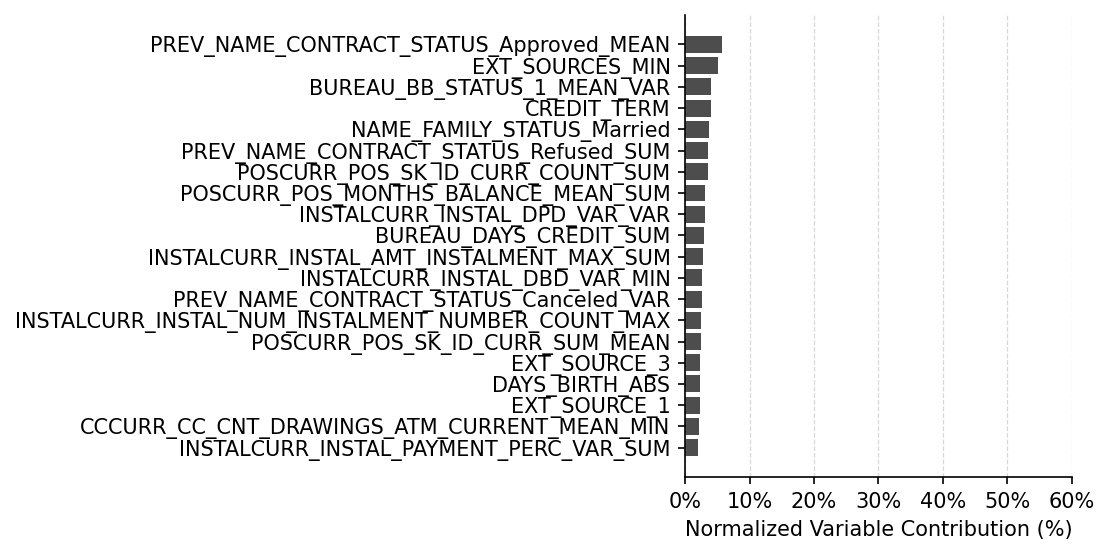

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


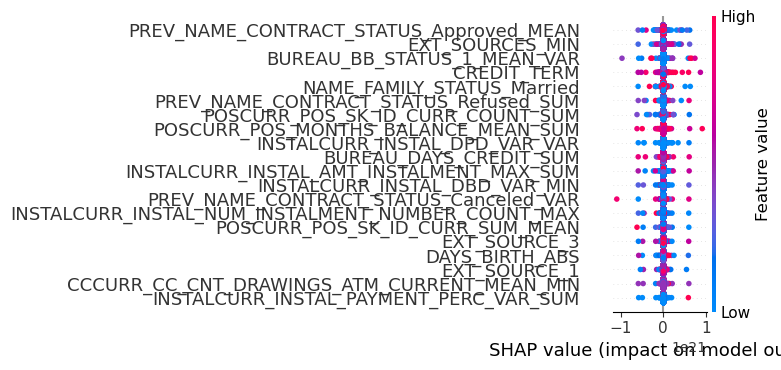

In [ ]:

import fasttreeshap as fts
import numpy as np
import pandas as pd

S_EXP = 2048  
RS    = 42

rf_model = rf_run["model"]
imputer  = rf_run["imputer"]

X_exp = X_test.sample(n=min(S_EXP, len(X_test)), random_state=RS)
X_exp_imp = imputer.transform(X_exp).astype(np.float64, copy=False)

if hasattr(rf_model, "n_features_in_"):
    assert X_exp_imp.shape[1] == rf_model.n_features_in_, \
        f"列数不一致：X_exp_imp={X_exp_imp.shape[1]}, model={rf_model.n_features_in_}"

assert np.isfinite(X_exp_imp).all(), "X_exp_imp 出现 NaN/Inf，请先排查"

explainer = fts.TreeExplainer(
    rf_model,
    algorithm="auto",
    model_output="raw",  
    n_jobs=-1
)

shap_values = explainer.shap_values(X_exp_imp, check_additivity=False)

if isinstance(shap_values, list):
    shap_matrix = shap_values[1 if len(shap_values) > 1 else 0]
else:
    shap_matrix = shap_values


imp_df = (
    pd.DataFrame({
        "feature": X_test.columns,
        "mean_abs_shap": np.abs(shap_matrix).mean(axis=0)
    })
    .sort_values("mean_abs_shap", ascending=False)
    .reset_index(drop=True)
)
print("\n[fasttreeshap] Top-20 全局重要性（raw 空间）：")
print(imp_df.head(20))





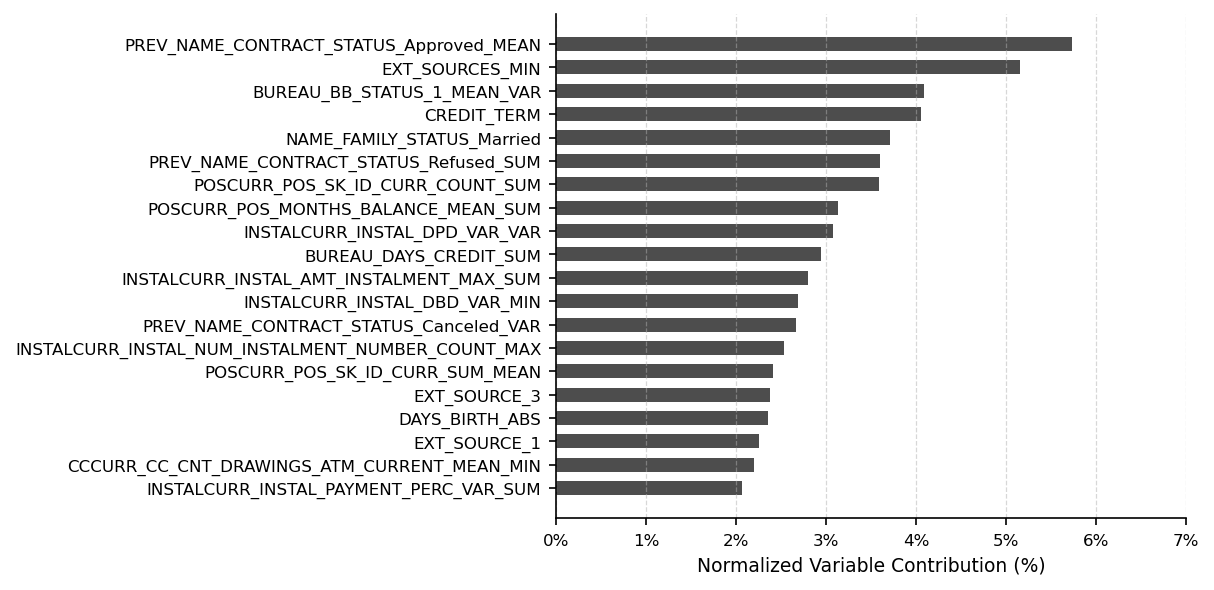

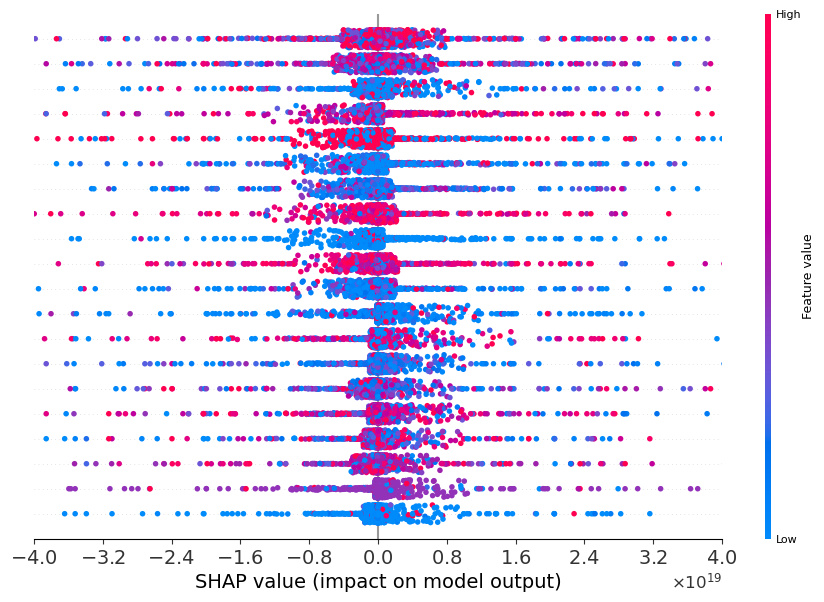

In [27]:

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd


mpl.rcParams.update({
    "font.size": 8,       
    "axes.labelsize": 9,   
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
})

X_exp_imp_df = pd.DataFrame(X_exp_imp, columns=X_test.columns, index=X_exp.index)

TOP_K = 20               

imp_df["pct"] = imp_df["mean_abs_shap"] / imp_df["mean_abs_shap"].sum() * 100.0
bar_df = imp_df.head(TOP_K).copy()

fig, ax = plt.subplots(figsize=(7.5, 4.2), dpi=150)
ax.barh(bar_df["feature"], bar_df["pct"], color="#4d4d4d", height=0.6)

ax.invert_yaxis()

ax.set_xlabel("Normalized Variable Contribution (%)")
ax.set_ylabel("")

ax.set_xlim(0, 7)
ax.set_xticks(np.arange(0, 8, 1)) 
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.0f}%"))

for s in ("top", "right"):
    ax.spines[s].set_visible(False)
ax.grid(True, axis="x", linestyle="--", linewidth=0.6, alpha=0.5)

plt.subplots_adjust(left=0.42, bottom=0.15, right=0.98, top=0.95)
plt.savefig("shap_bar.png", dpi=300, bbox_inches="tight")

plt.show()

top_features = imp_df.head(TOP_K)["feature"].tolist()
cols_idx = [X_exp_imp_df.columns.get_loc(c) for c in top_features]
shap_vals_top = shap_matrix[:, cols_idx]
X_top = X_exp_imp_df[top_features]

try:

    from matplotlib.ticker import ScalarFormatter, FuncFormatter

    EXP = 20                               
    HALFSPAN = 0.4 * (10 ** EXP)           

    top_features = imp_df.head(TOP_K)["feature"].tolist()
    cols_idx = [X_exp_imp_df.columns.get_loc(c) for c in top_features]
    shap_vals_top = shap_matrix[:, cols_idx]
    X_top = X_exp_imp_df[top_features]

    import shap
    X_top_anon = X_top.copy()
    X_top_anon.columns = [""] * len(top_features)

    shap.summary_plot(
        shap_vals_top,
        X_top_anon,
        feature_names=[""] * len(top_features),
        plot_type="dot",
        plot_size=(10, 7),
        max_display=TOP_K,
        show=False
    )

    fig = plt.gcf()
    ax  = plt.gca()

    ax.tick_params(axis='x', labelsize=14)       
    ax.xaxis.label.set_size(14)                 
    ax.xaxis.get_offset_text().set_size(12)      


    ax.set_yticks([])
    ax.set_ylabel("")


    ax.set_xlim(-HALFSPAN, HALFSPAN)
    ax.set_xticks(np.linspace(-HALFSPAN, HALFSPAN, 11)) 
    sf = ScalarFormatter(useMathText=True)
    sf.set_scientific(True)
    sf.set_powerlimits((0, 0))          
    ax.xaxis.set_major_formatter(sf)

    plt.setp(ax.get_xticklabels(), fontsize=14)

    if len(fig.axes) > 1:
        cax = fig.axes[-1]
        cax.tick_params(labelsize=8)
        cax.yaxis.label.set_size(9)

    plt.subplots_adjust(left=0.12, bottom=0.20, right=0.98, top=0.95)
    plt.savefig("shap_beeswarm.png", dpi=300, bbox_inches="tight")
    plt.show()

except Exception:

    X_top_anon = X_top.copy()
    X_top_anon.columns = [""] * len(top_features)
    fts.summary_plot(
        shap_vals_top,
        X_top_anon,
        feature_names=[""] * len(top_features),
        plot_type="dot",
        show=False
    )
    fig = plt.gcf()
    ax = plt.gca()
    ax.set_yticks([])
    ax.set_ylabel("")
    plt.setp(ax.get_xticklabels(), fontsize=8)
    ax.xaxis.label.set_size(9)
    if len(fig.axes) > 1:
        cax = fig.axes[-1]
        cax.tick_params(labelsize=8)
        cax.yaxis.label.set_size(9)
    plt.subplots_adjust(left=0.12, bottom=0.18, right=0.98, top=0.95)
    plt.show()

In [4]:

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

def train_rf_with_topk(
    *,
    k_list,
    imp_df: pd.DataFrame,
    X_train: pd.DataFrame,
    y: pd.Series,
    base_run: dict,
    rf_params: dict = None
):

    if rf_params is None:
        rf_params = dict(
            n_estimators=1000,
            max_depth=None,
            max_features="sqrt",
            n_jobs=-1,
            class_weight="balanced",
            random_state=42
        )

    tr_idx = base_run["train_index"]
    val_idx = base_run["valid_index"]

    results = []
    for k in k_list:
        k_eff = int(min(k, len(imp_df)))
        top_feats = imp_df["feature"].head(k_eff).tolist()

        X_tr = X_train.iloc[tr_idx][top_feats]
        X_val = X_train.iloc[val_idx][top_feats]
        y_tr = y.iloc[tr_idx]
        y_val = y.iloc[val_idx]

 
        imputer_k = SimpleImputer(strategy="median")
        X_tr_imp  = np.ascontiguousarray(imputer_k.fit_transform(X_tr).astype("float32", copy=False))
        X_val_imp = np.ascontiguousarray(imputer_k.transform(X_val).astype("float32", copy=False))


        rf_k = RandomForestClassifier(**rf_params)
        rf_k.fit(X_tr_imp, y_tr)


        val_pred = rf_k.predict_proba(X_val_imp)[:, 1]
        val_auc  = roc_auc_score(y_val, val_pred)

        print(f"[Top-{k_eff:>4}] features={k_eff:>4} | Validation AUC = {val_auc:.5f}")

        results.append({
            "k": k_eff,
            "features": top_feats,
            "model": rf_k,
            "imputer": imputer_k,
            "val_auc": float(val_auc),
            "val_pred": val_pred,
            "train_index": tr_idx,
            "valid_index": val_idx,
        })


    baseline_auc = float(base_run["val_auc"])
    baseline_row = {"k": len(feature_names), "val_auc": baseline_auc}
    summary_rows = [{"k": r["k"], "val_auc": r["val_auc"]} for r in results] + [baseline_row]
    summary_df = pd.DataFrame(summary_rows).sort_values("k").reset_index(drop=True)

    print("\n=== AUC vs. #Features (SHAP Top-K) ===")
    print(summary_df)

    return results, summary_df

k_list = [200,  400, 600, 800,1000,1200,1400,1600,1800,2000,2200,2400,2600,2800,3000,3200,3400,3600,3800,4000]
topk_runs, topk_summary = train_rf_with_topk(
    k_list=k_list,
    imp_df=imp_df,       
    X_train=X_train,
    y=y,
    base_run=rf_run,     
    rf_params=dict(
        n_estimators=1000,
        max_depth=None,
        max_features="sqrt",
        n_jobs=-1,
        class_weight="balanced",
        random_state=42
    )
)




[Top- 200] features= 200 | Validation AUC = 0.75840
[Top- 400] features= 400 | Validation AUC = 0.75828
[Top- 600] features= 600 | Validation AUC = 0.75995
[Top- 800] features= 800 | Validation AUC = 0.75956
[Top-1000] features=1000 | Validation AUC = 0.75990
[Top-1200] features=1200 | Validation AUC = 0.76007
[Top-1400] features=1400 | Validation AUC = 0.76051
[Top-1600] features=1600 | Validation AUC = 0.75783
[Top-1800] features=1800 | Validation AUC = 0.75964
[Top-2000] features=2000 | Validation AUC = 0.76006
[Top-2200] features=2200 | Validation AUC = 0.75951
[Top-2400] features=2400 | Validation AUC = 0.76063
[Top-2600] features=2600 | Validation AUC = 0.76044
[Top-2800] features=2800 | Validation AUC = 0.75827
[Top-3000] features=3000 | Validation AUC = 0.75920
[Top-3200] features=3200 | Validation AUC = 0.75909
[Top-3400] features=3400 | Validation AUC = 0.75932
[Top-3600] features=3600 | Validation AUC = 0.76080
[Top-3800] features=3800 | Validation AUC = 0.75835
[Top-4000] f

In [5]:

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
import numpy as np
import pandas as pd
import os

TOPK = 3600


assert "imp_df" in globals(), "未发现 imp_df，请先运行 fasttreeshap 计算并生成 imp_df。"
ranked_feats = imp_df["feature"].tolist()
top_feats_1200 = [f for f in ranked_feats if f in X_train.columns][:TOPK]
if len(top_feats_1200) < TOPK:
    print(f"[WARN] 仅找到 {len(top_feats_1200)} 个在 X_train 中存在的 SHAP 排名特征（少于 {TOPK}）。")

X_tr_sub = X_train.loc[:, top_feats_1200]
X_te_sub = X_test.loc[:, top_feats_1200]

imputer_1200 = SimpleImputer(strategy="median")
X_tr_imp = np.ascontiguousarray(imputer_1200.fit_transform(X_tr_sub).astype("float32", copy=False))
X_te_imp = np.ascontiguousarray(imputer_1200.transform(X_te_sub).astype("float32", copy=False))


if "rf_run" in globals() and isinstance(rf_run.get("model", None), RandomForestClassifier):
    rf_params = rf_run["model"].get_params()
else:
    rf_params = dict(
        n_estimators=1000,
        max_depth=None,
        max_features="sqrt",
        n_jobs=-1,
        class_weight="balanced",
        random_state=42
    )

rf_top1200 = RandomForestClassifier(**rf_params)
rf_top1200.fit(X_tr_imp, y)
print(f"[RF-Top{len(top_feats_1200)}] train={X_tr_imp.shape} done.")


test_proba_top1200 = rf_top1200.predict_proba(X_te_imp)[:, 1]
assert np.isfinite(test_proba_top1200).all(), "test_proba_top1200 出现 NaN/Inf，请排查。"
print(f"[RF-Top{len(top_feats_1200)}] inference on test={X_te_imp.shape} done. head: {test_proba_top1200[:5]}")


submission_df = None
try:
    test_id_df = pd.read_csv(os.path.join(DATA_DIR, "application_test.csv"), usecols=["SK_ID_CURR"])
    if len(test_id_df) == len(X_test):
        submission_df = pd.DataFrame({
            "SK_ID_CURR": test_id_df["SK_ID_CURR"].values,
            "TARGET": test_proba_top1200
        })
        out_path = os.path.join(os.getcwd(), f"rf_top{len(top_feats_1200)}_submission.csv")
        submission_df.to_csv(out_path, index=False)
        print(f"[SUBMIT] 保存提交文件：{out_path}")
        print(submission_df.head())
    else:
        print(f"[WARN] application_test.csv 行数({len(test_id_df)}) 与 X_test({len(X_test)}) 不一致，暂不写提交文件。")
except Exception as e:
    print(f"[WARN] 生成提交文件失败：{e}")


top1200_full = {
    "features": top_feats_1200,
    "imputer": imputer_1200,
    "model": rf_top1200,
    "test_pred_proba": test_proba_top1200,
    "submission_df": submission_df
}


[RF-Top3600] train=(307511, 3600) done.
[RF-Top3600] inference on test=(48744, 3600) done. head: [0.077 0.111 0.049 0.06  0.182]
[SUBMIT] 保存提交文件：/data/hanzhe/math_mid_term/rf_top3600_submission.csv
   SK_ID_CURR  TARGET
0      100001   0.077
1      100005   0.111
2      100013   0.049
3      100028   0.060
4      100038   0.182
